# Choosing a colorscale

Here we will showcase a few different options for creating colormaps for grids. 

Import the modules

In [13]:
import os
from pathlib import Path

import geopandas as gpd
import pygmt
import verde as vd

from polartoolkit import fetch, maps, regions

In [14]:
# set default to southern hemisphere for this notebook
os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

Use the PolarToolkit `fetch` module to download the data and return the grid as an xarray.DataArrays

In [15]:
bed = fetch.bedmap2(
    layer="bed",
    region=regions.lake_vostok,
)

## Existing colormap

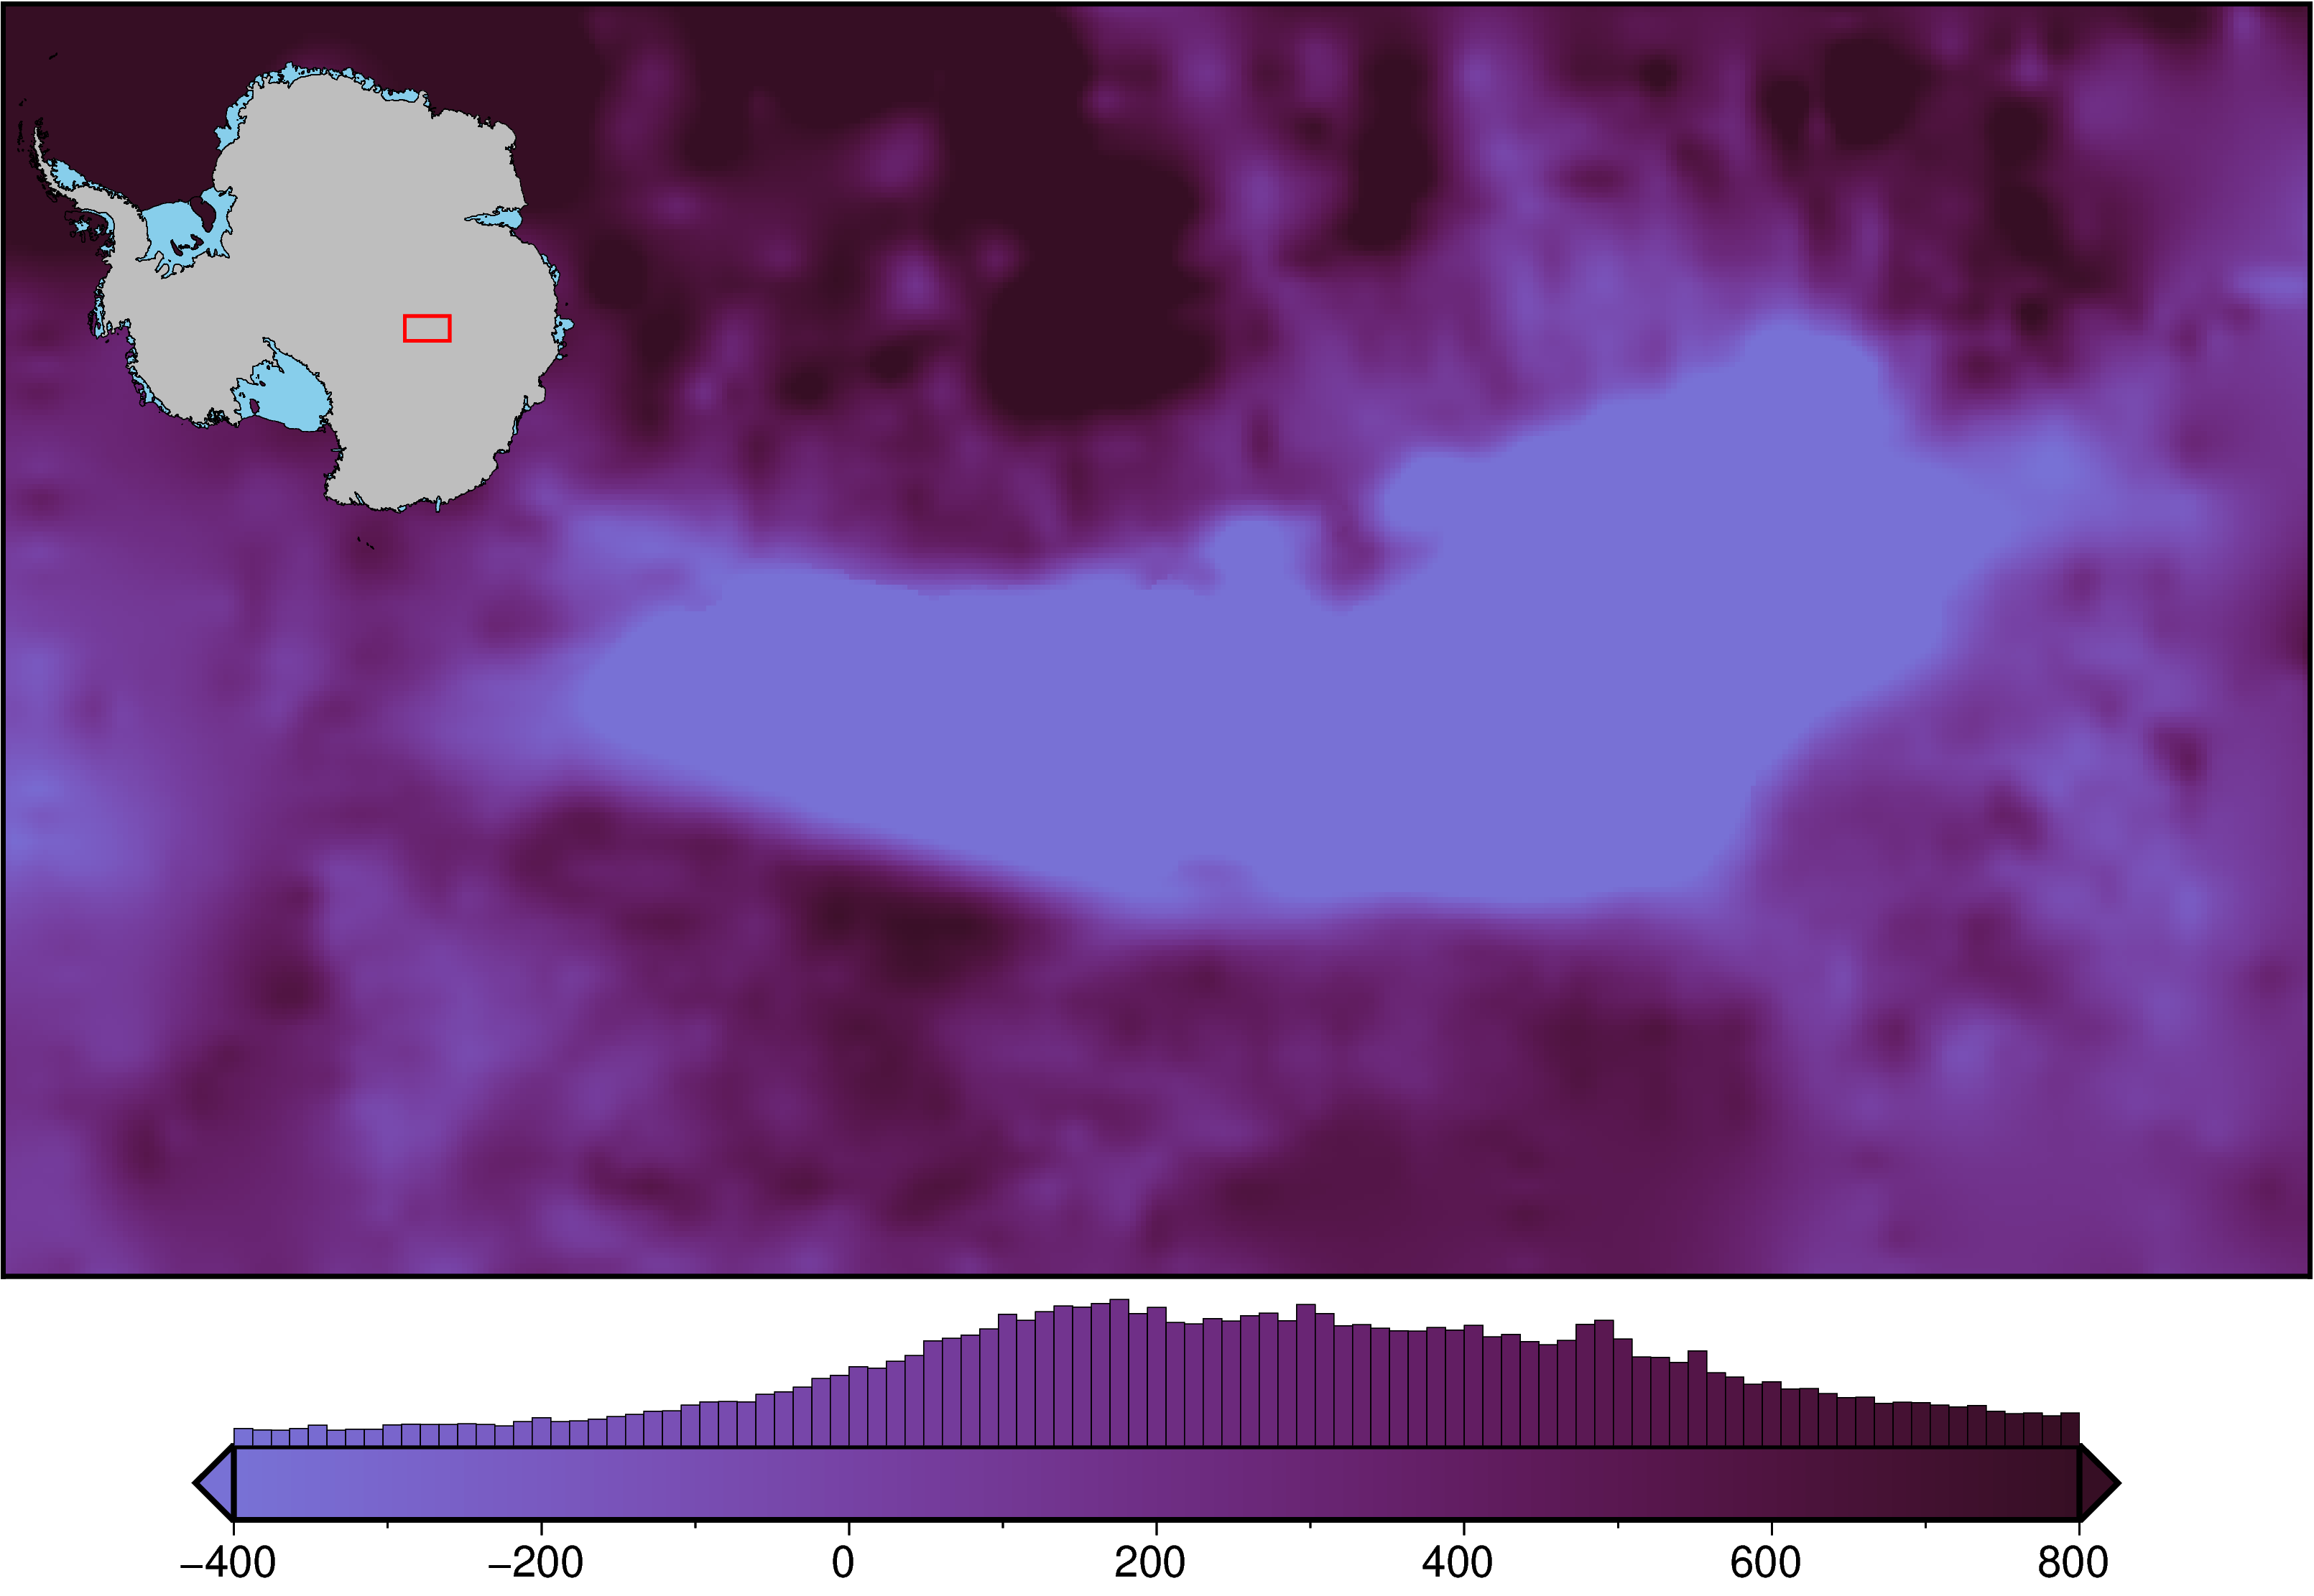

In [16]:
# create a pygmt colormap
pygmt.makecpt(
    cmap="dense",
    series=[-400, 800],  # set limits of grid values
    truncate=[0.5, 1],  # use only a portion of the colorscale
    output="test.cpt",  # name of output file
    background=True,  # make colors outside of range equal to limits
)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="test.cpt",  # use created colormap
)

# delete cpt file
Path.unlink("test.cpt")

fig.show()

grd2cpt [WARNING]: matter is a discrete CPT. You can stretch it (-T<min>/<max>) but not interpolate it (-T<min>/<max>/<inc>).
grd2cpt [WARNING]: Selecting the given range and ignoring the increment setting.


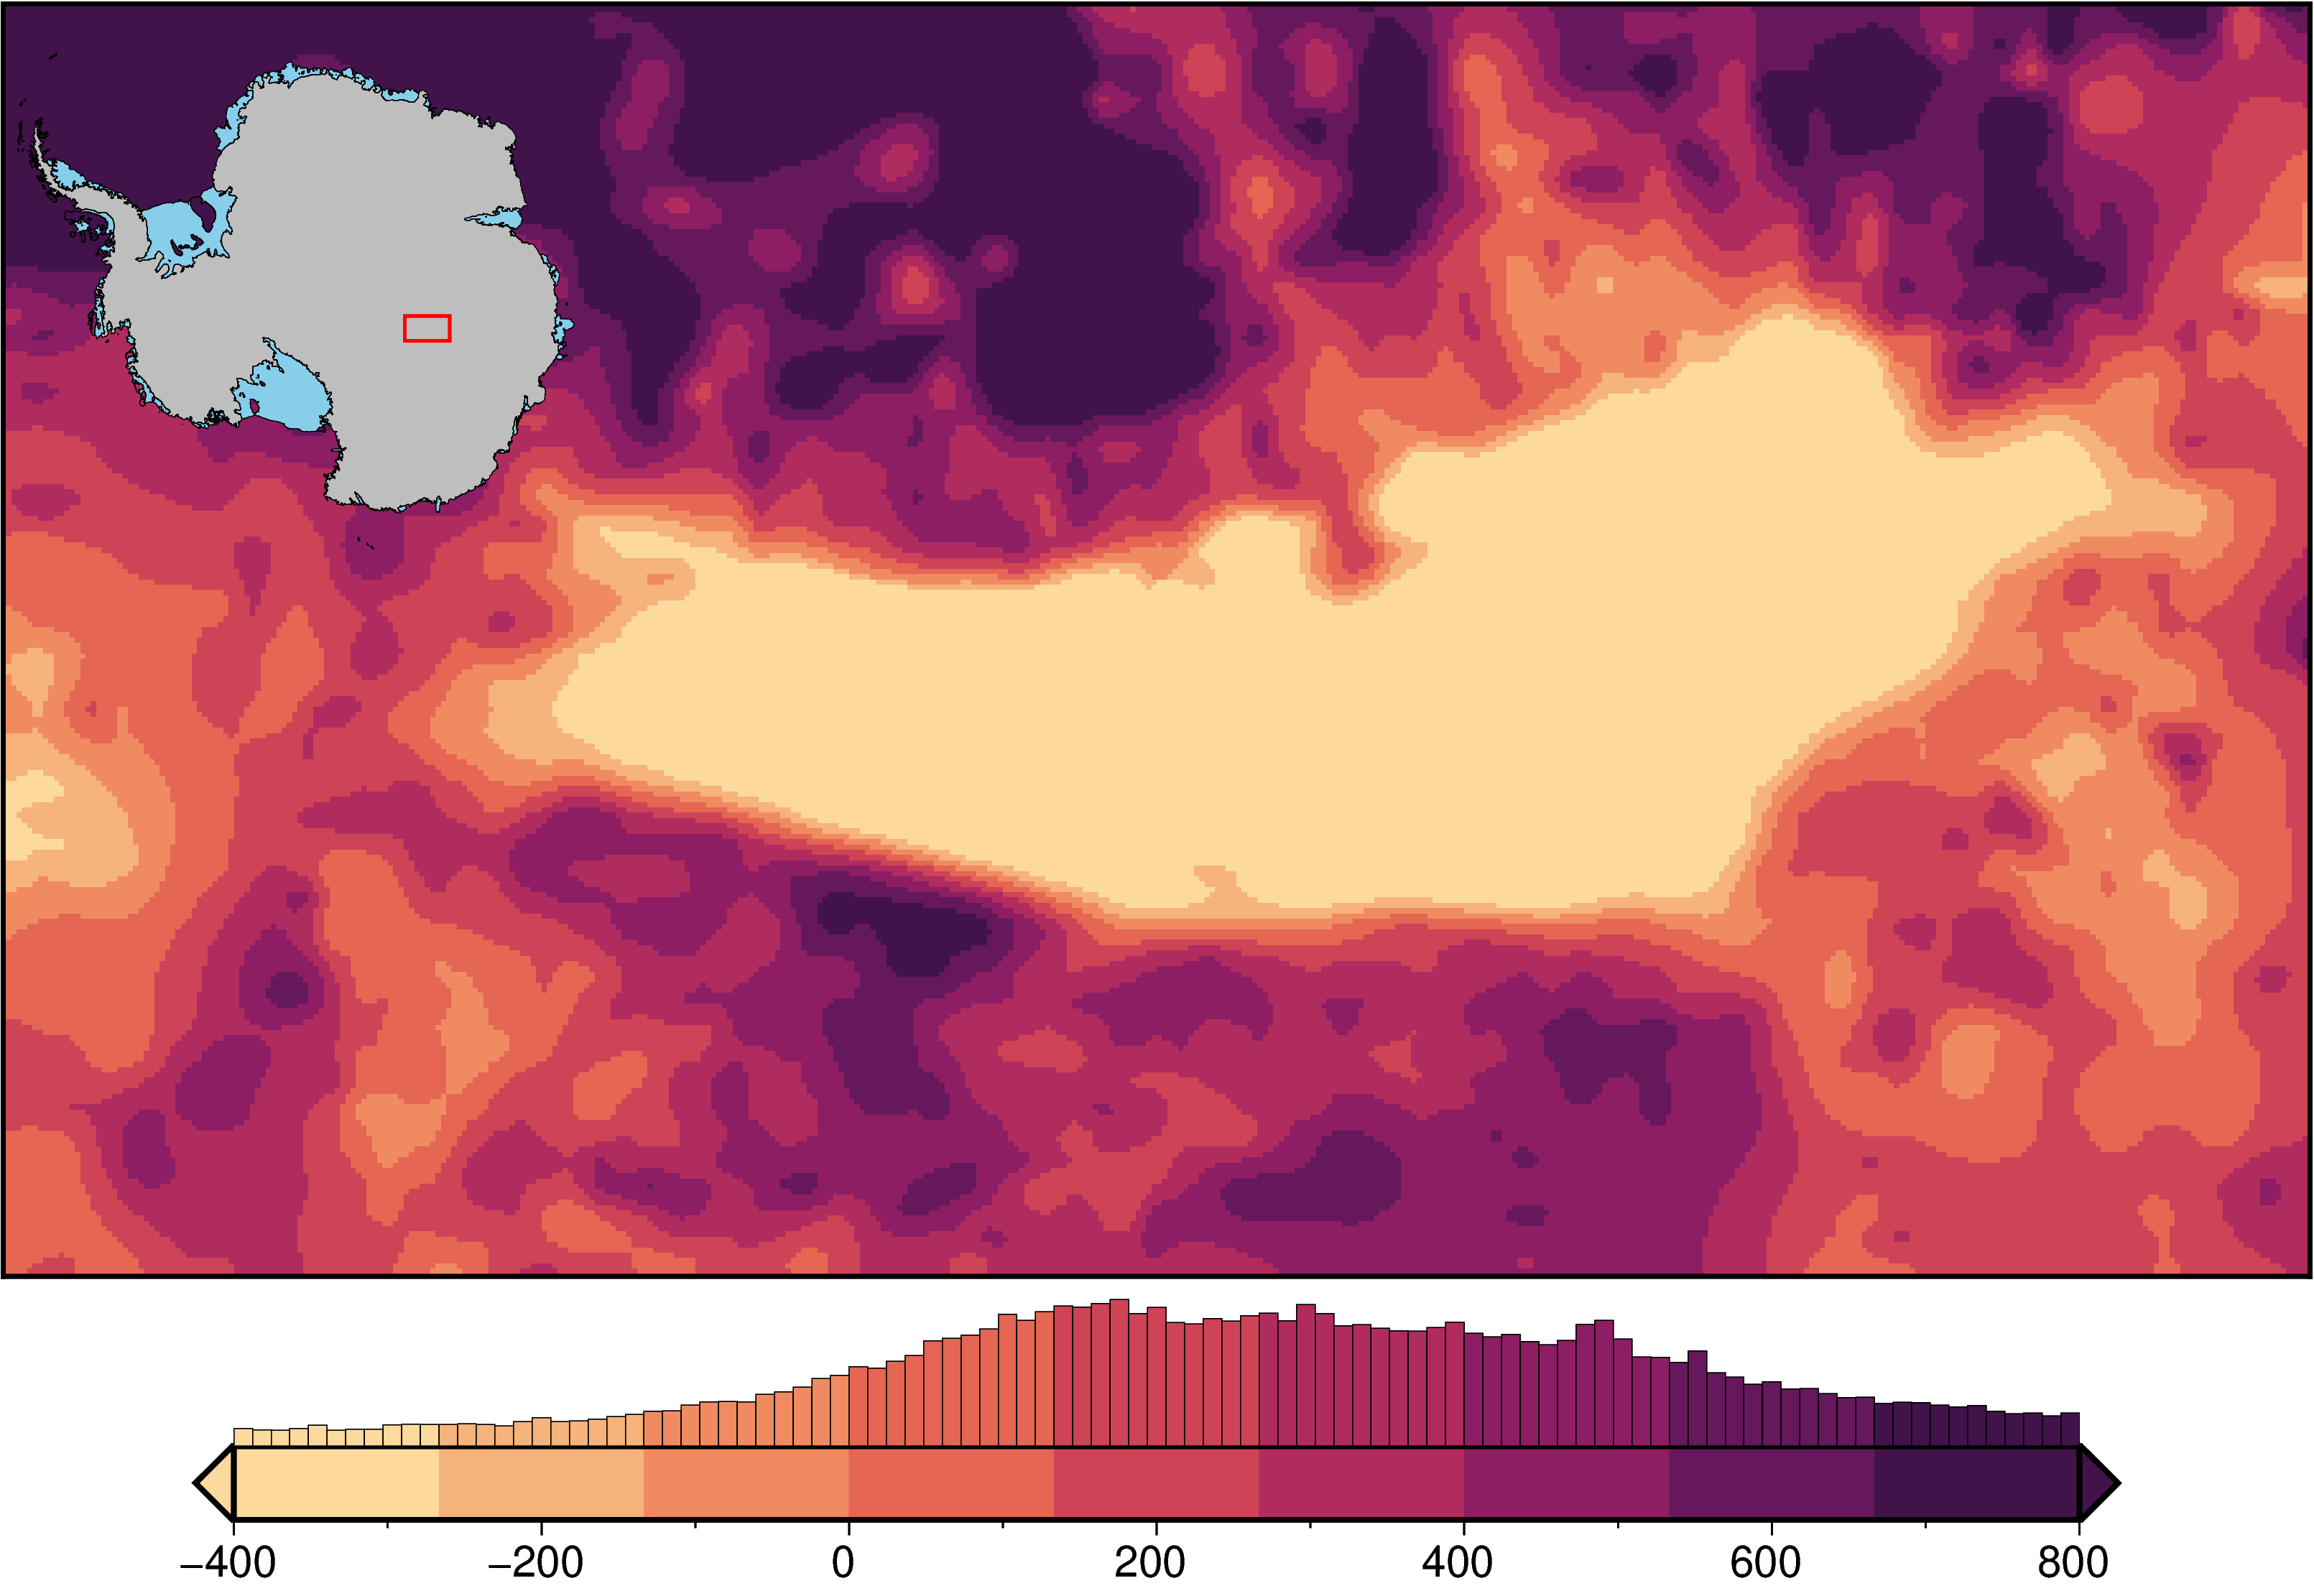

In [17]:
# create a pygmt histogram equalized colormap
pygmt.grd2cpt(
    bed,
    cmap="matter",
    limit=[-400, 800],  # set limits of grid values
    nlevels=10,  # use 10 discrete colors
    output="test.cpt",  # name of output file
    background=True,  # make colors outside of range equal to limits
)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="test.cpt",  # use created colormap
)

# delete cpt file
Path.unlink("test.cpt")

fig.show()

## Defaults settings

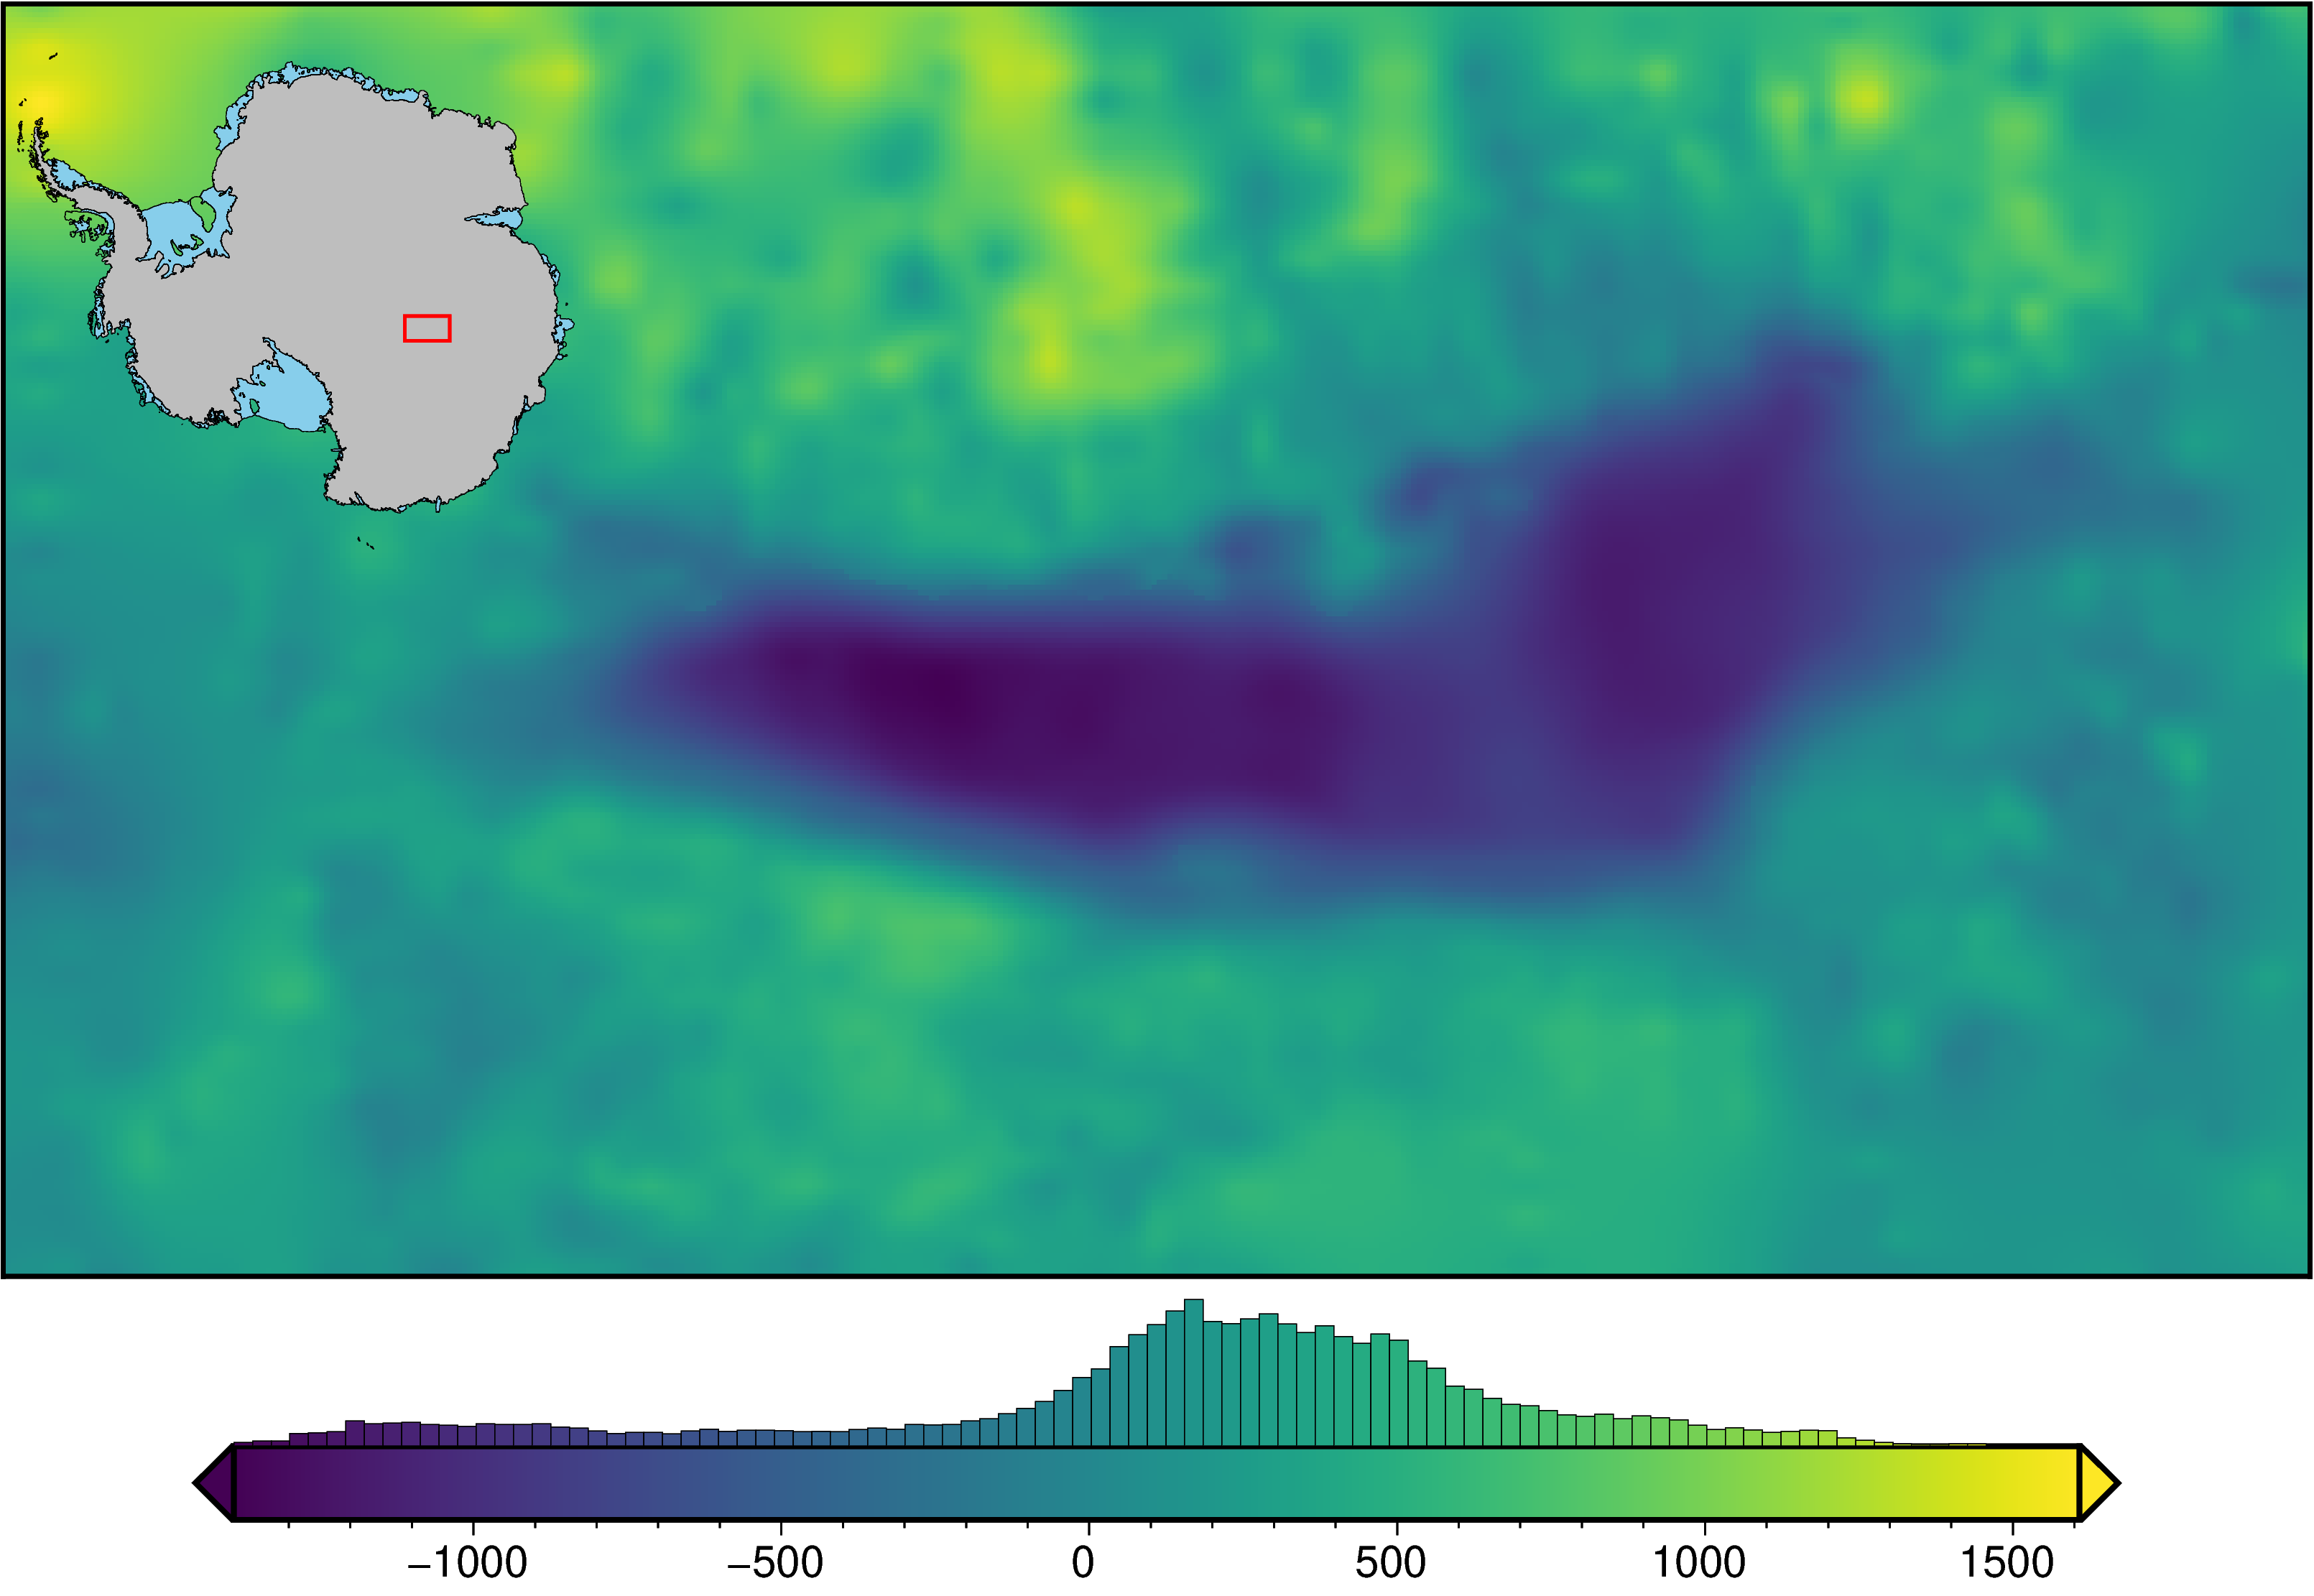

In [18]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
)

fig.show()

## Basic options

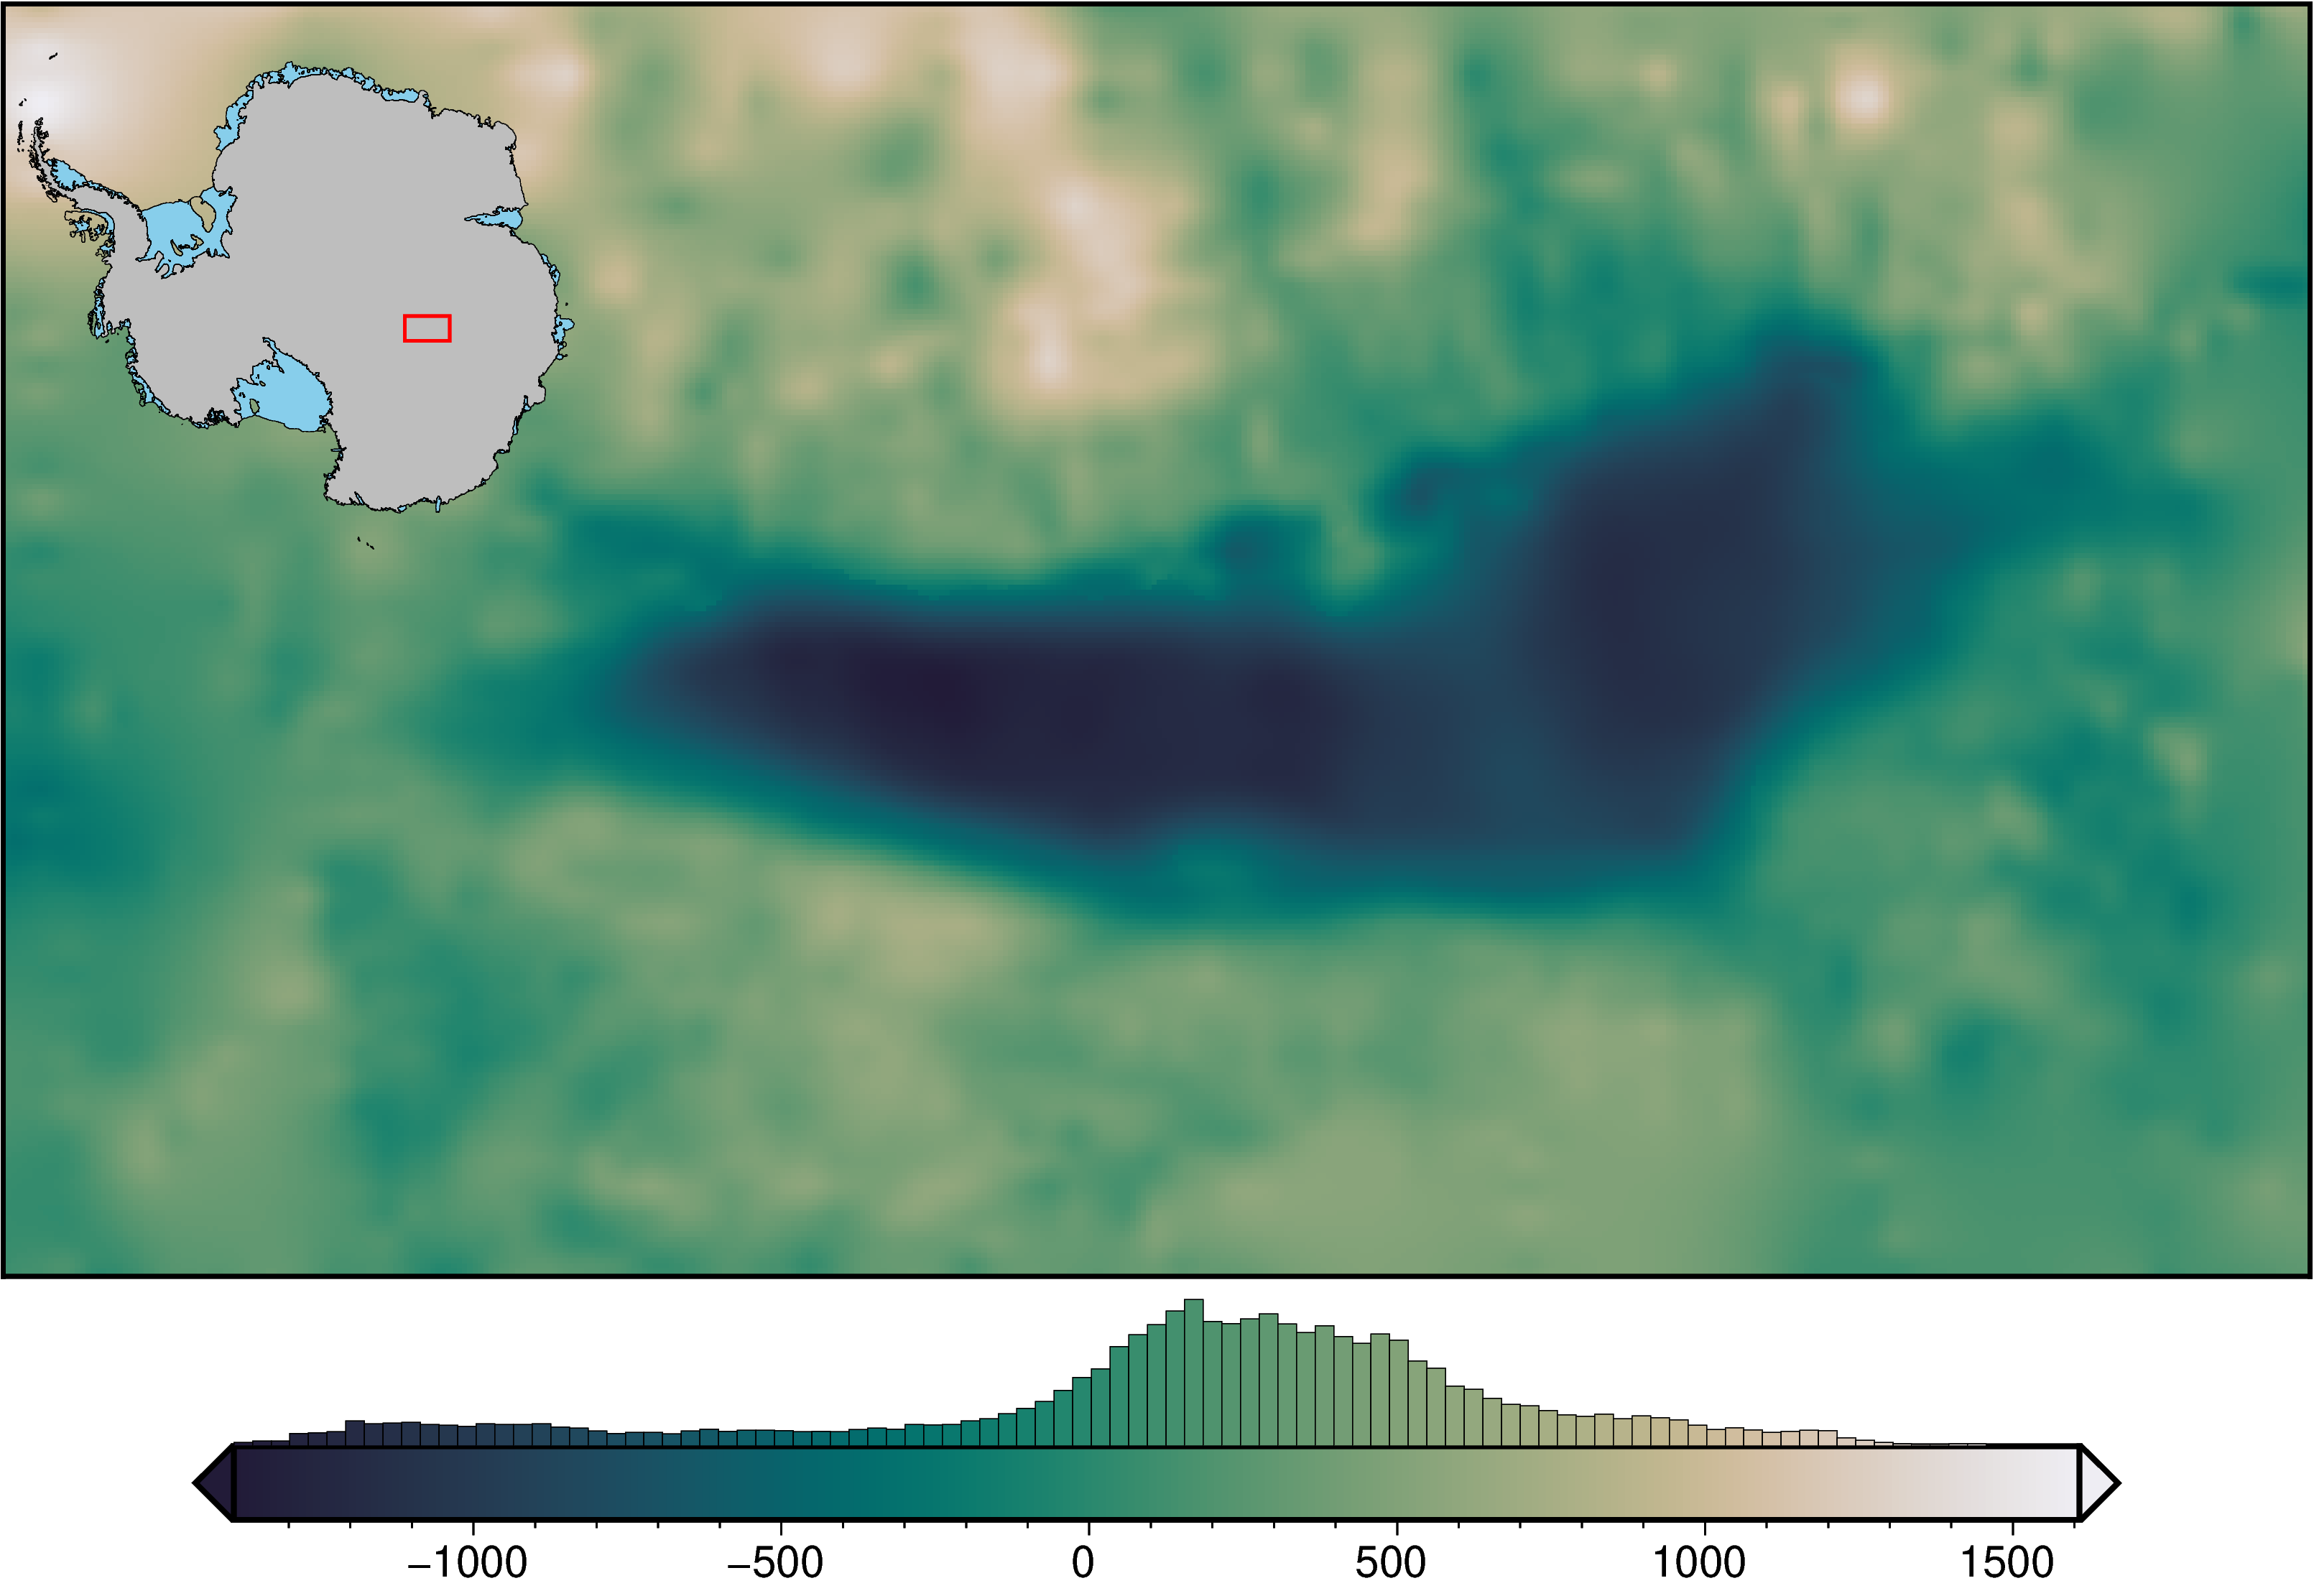

In [19]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="rain",  # change the colormap
    reverse_cpt=True,  # reverse the colors
)

fig.show()

## Customize color limits

### Manually set limits

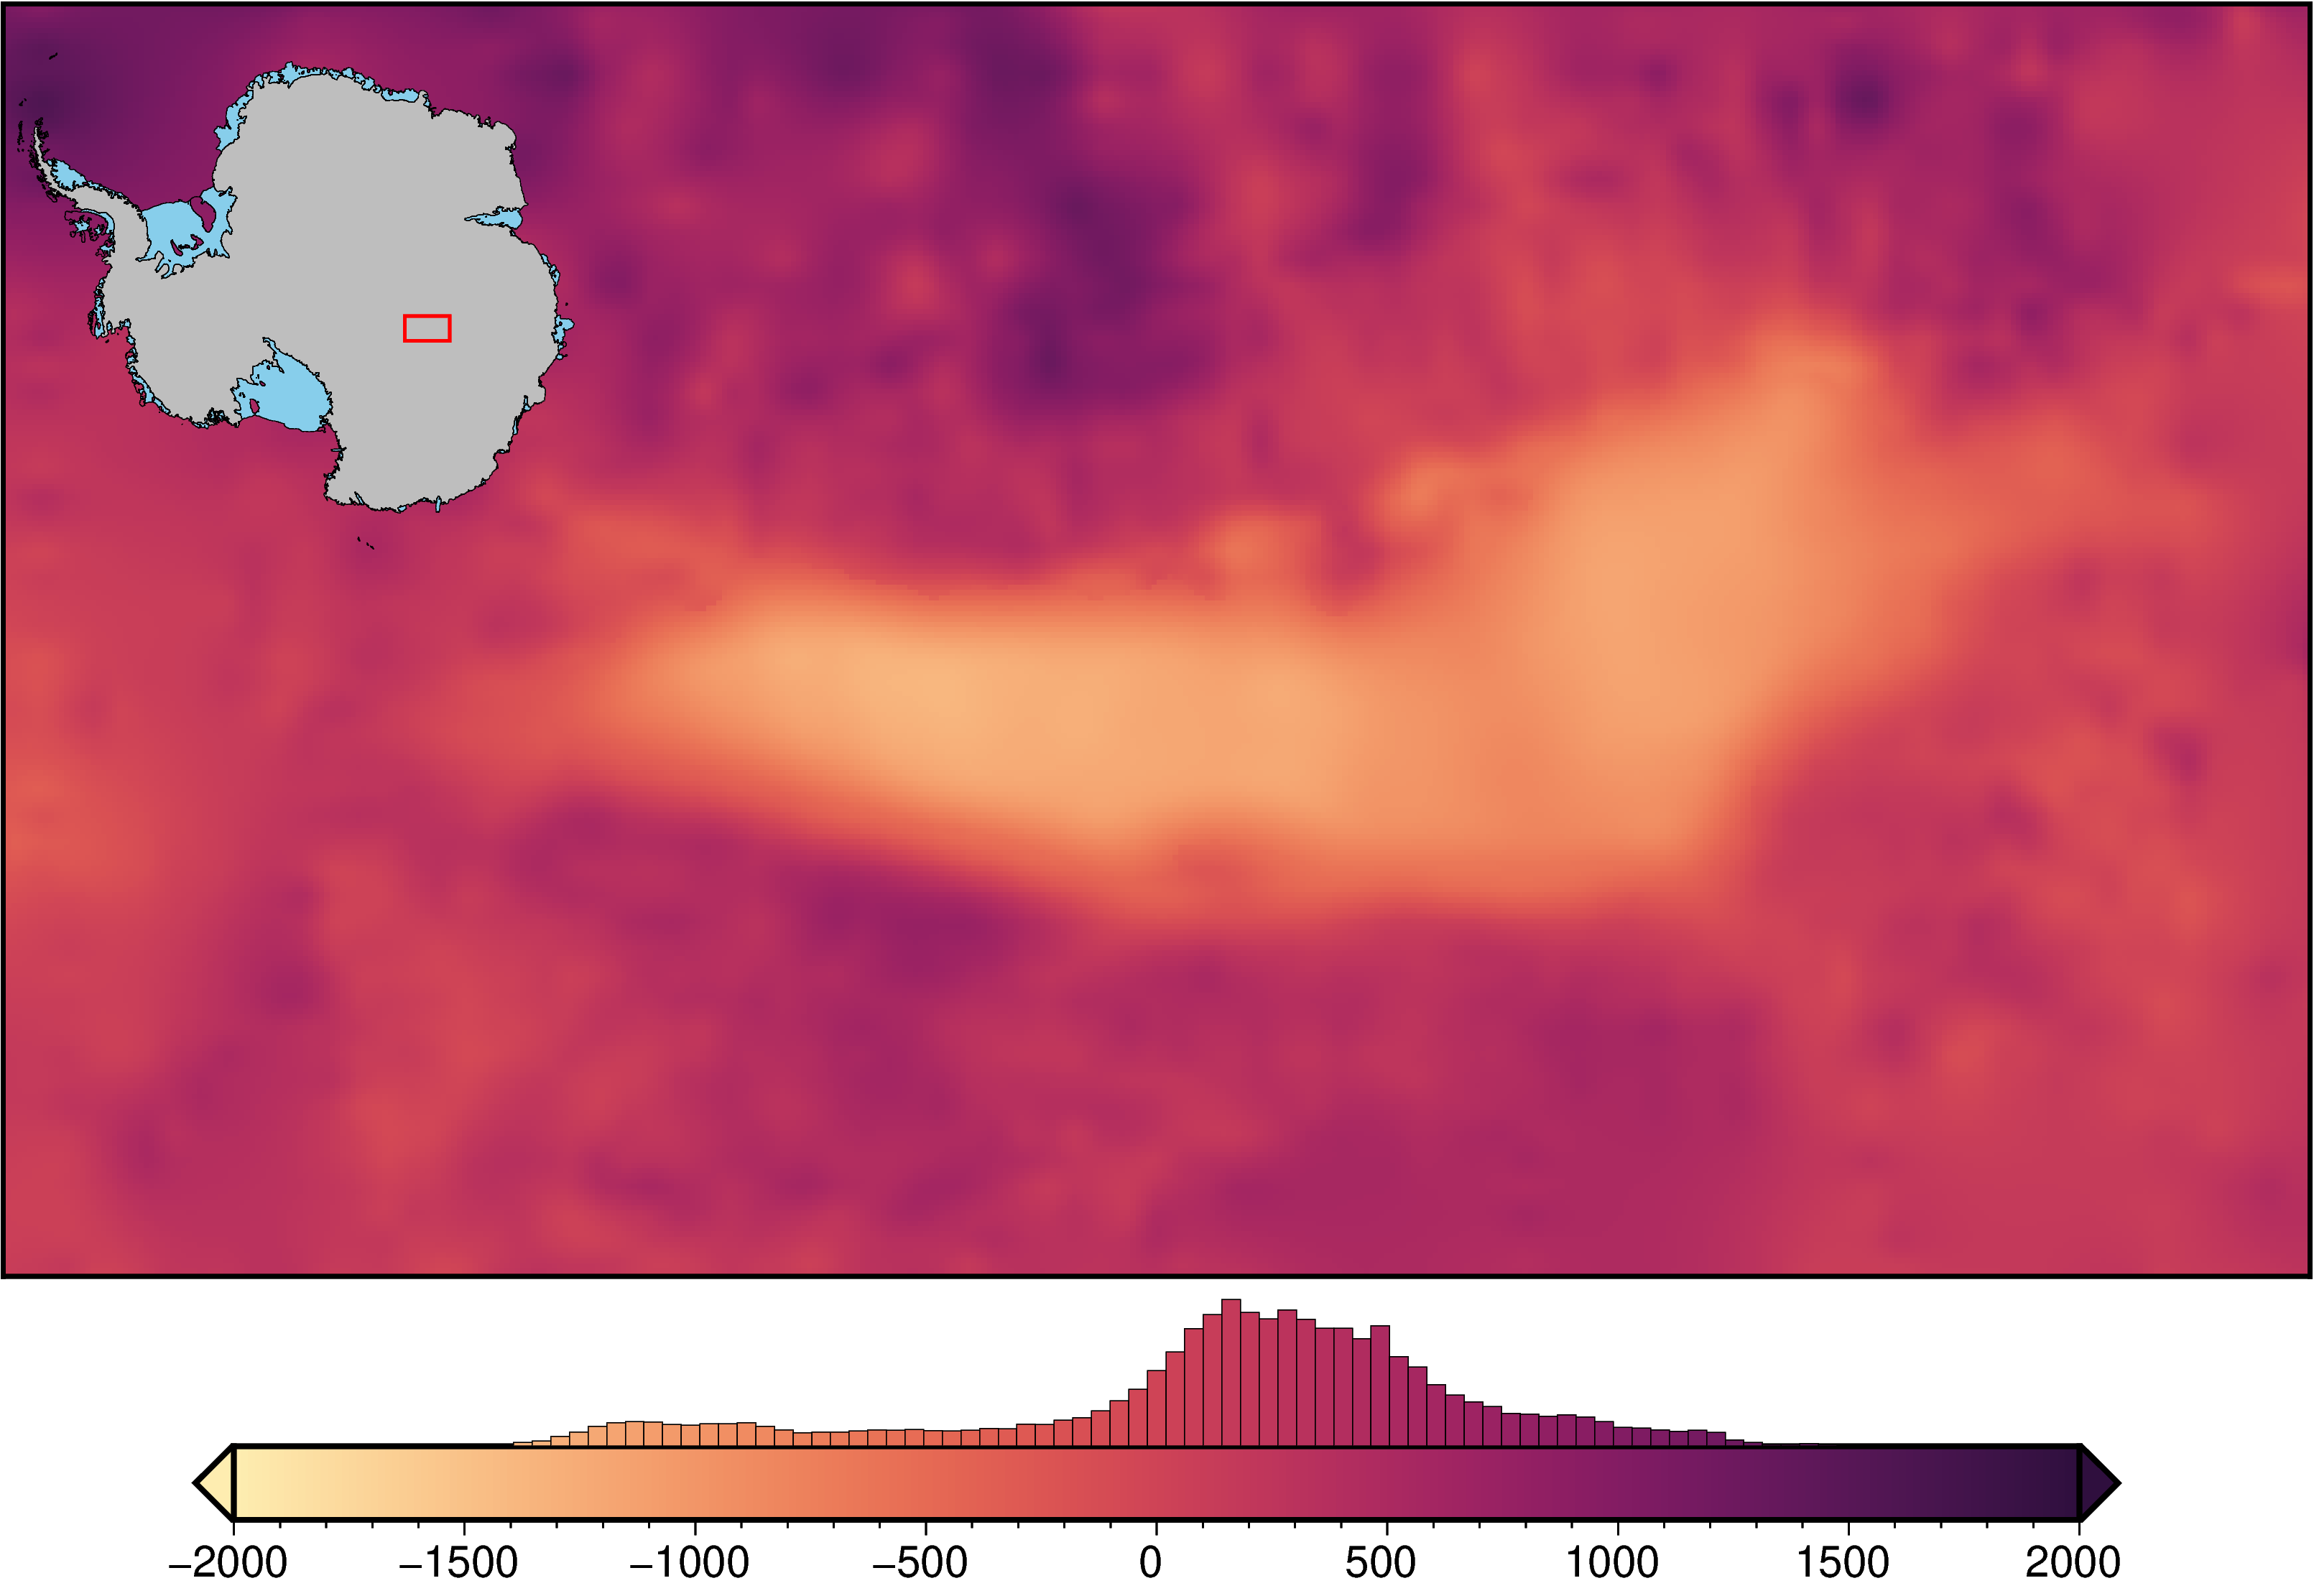

In [20]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    cpt_lims=[-2000, 2000],  # change the colorbar limits
)

fig.show()

### Set "robust" limits
This uses the 2nd and 98th percentiles of the data as the limits to omit outliers

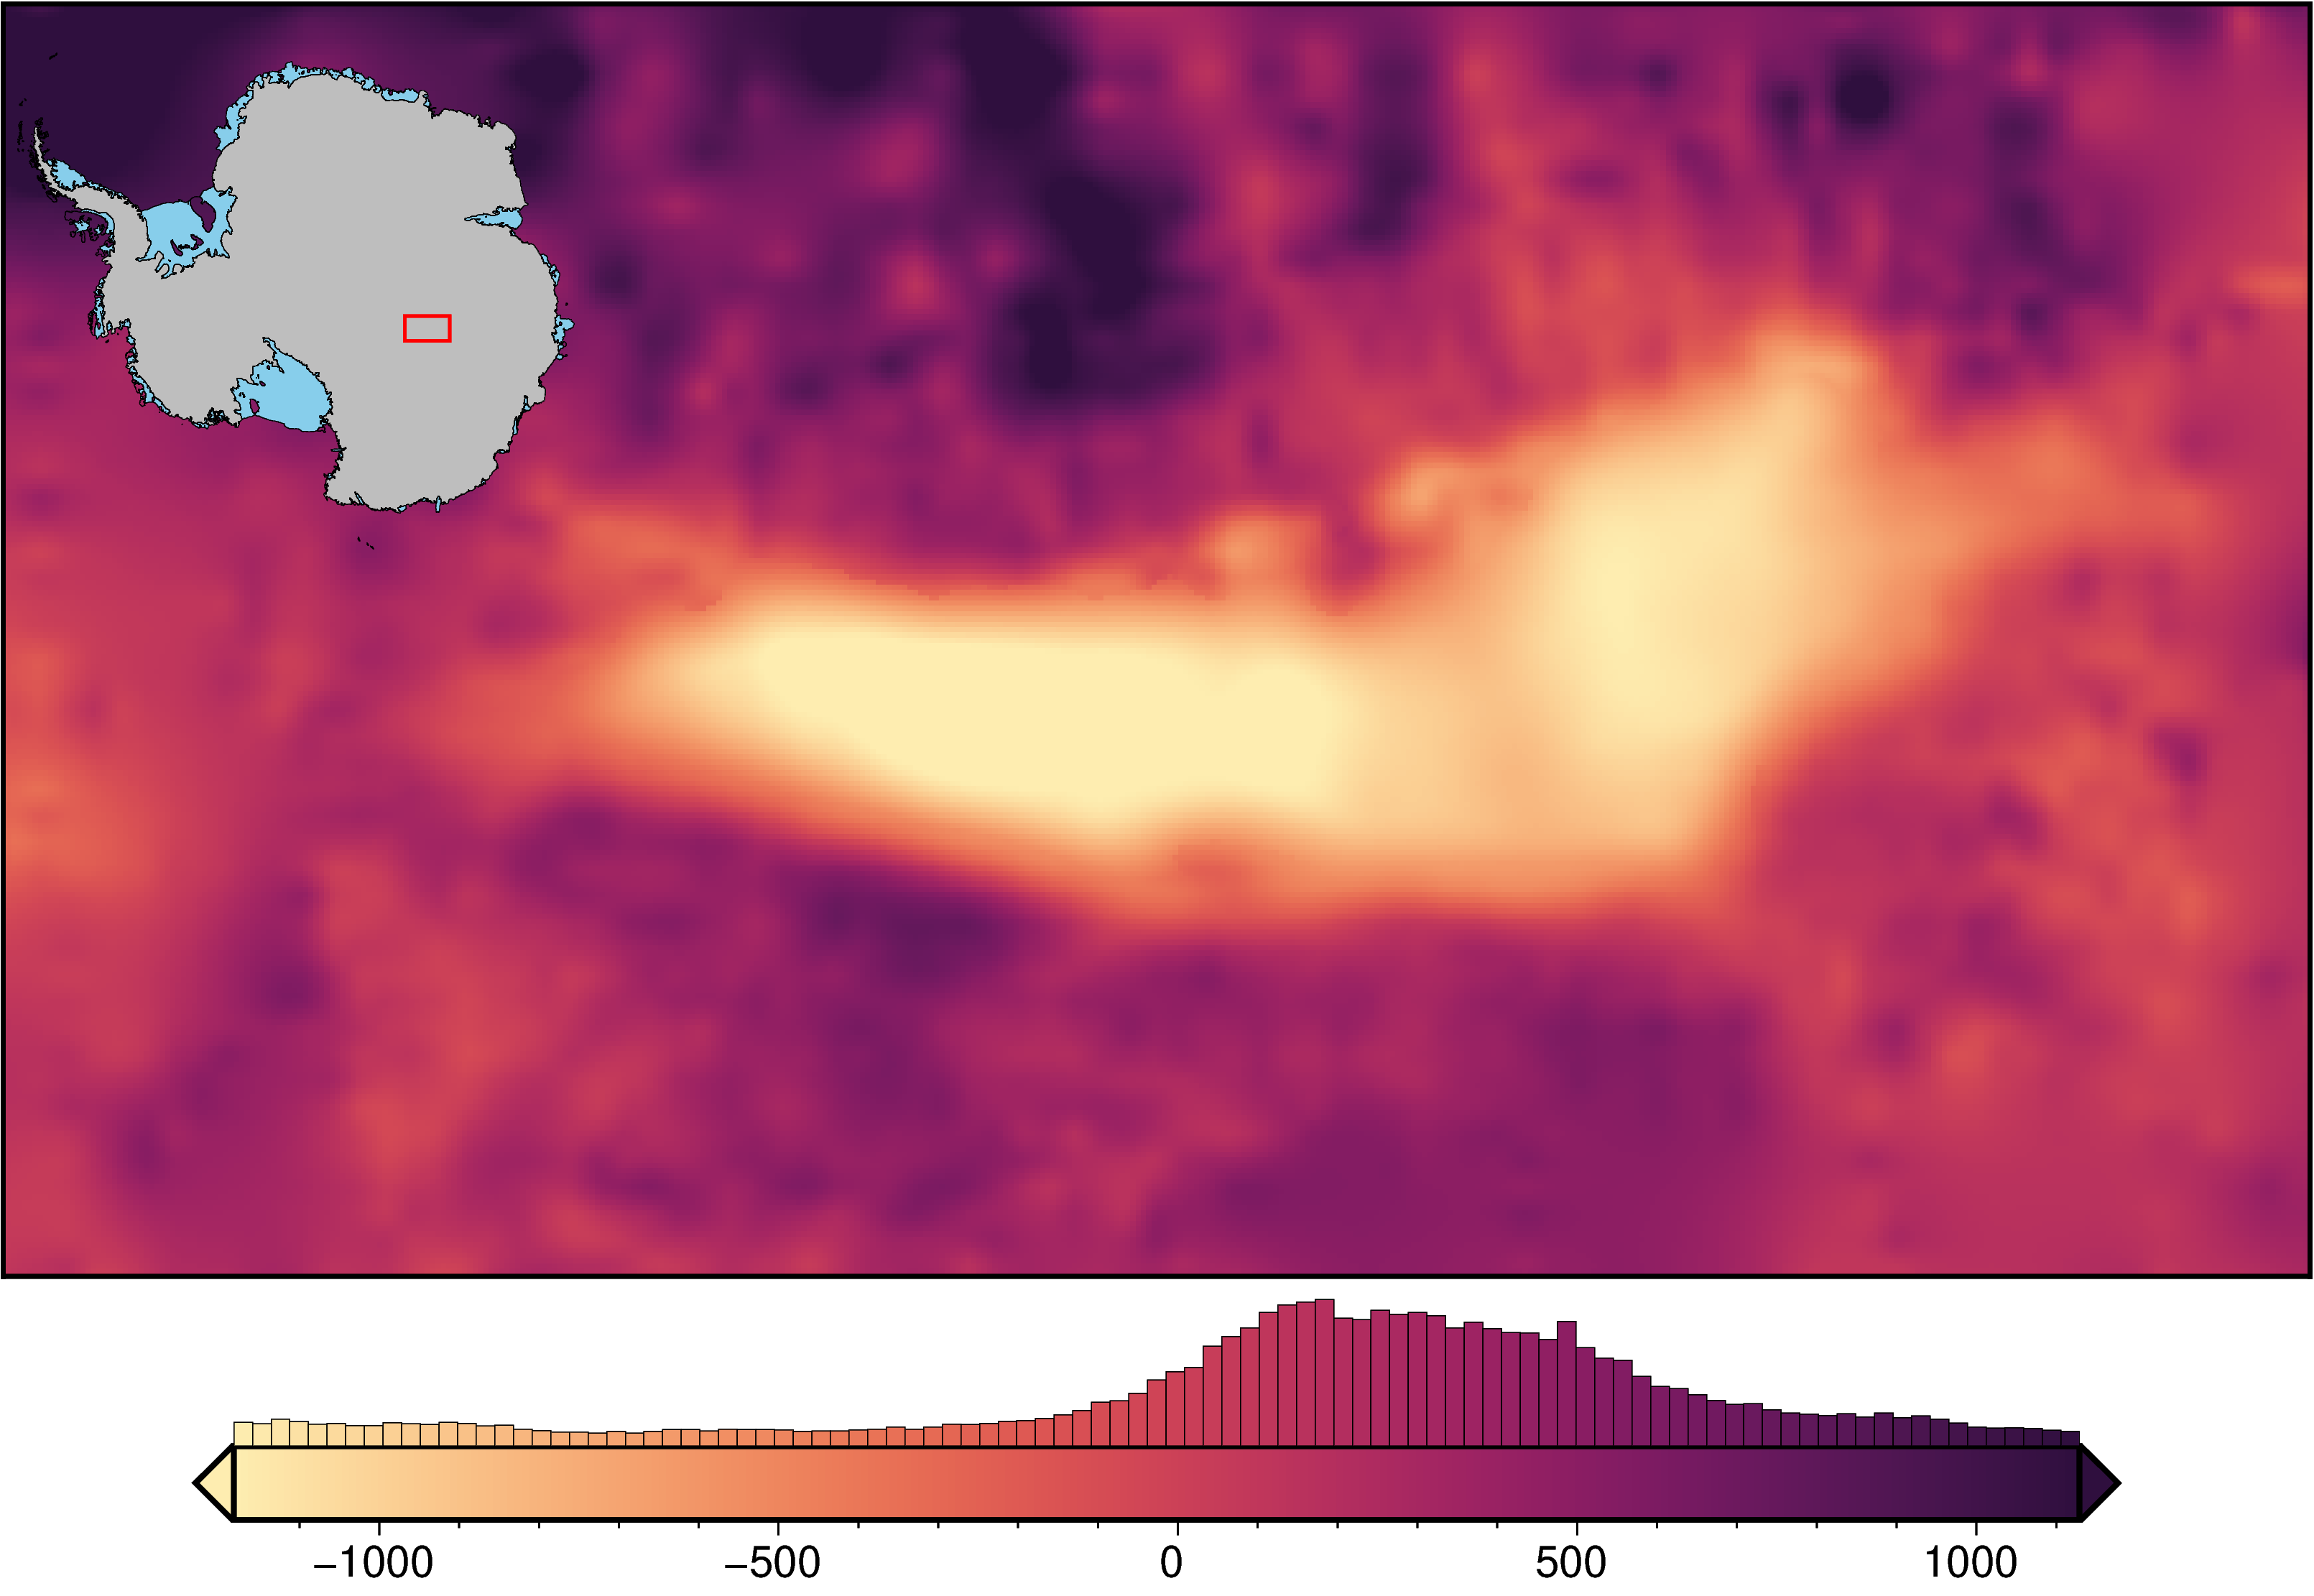

In [21]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    robust=True,  # set the color limits to the 2nd and 98th percentiles of the data
)

fig.show()

### Subset region limits
Use a subset region to define the limits

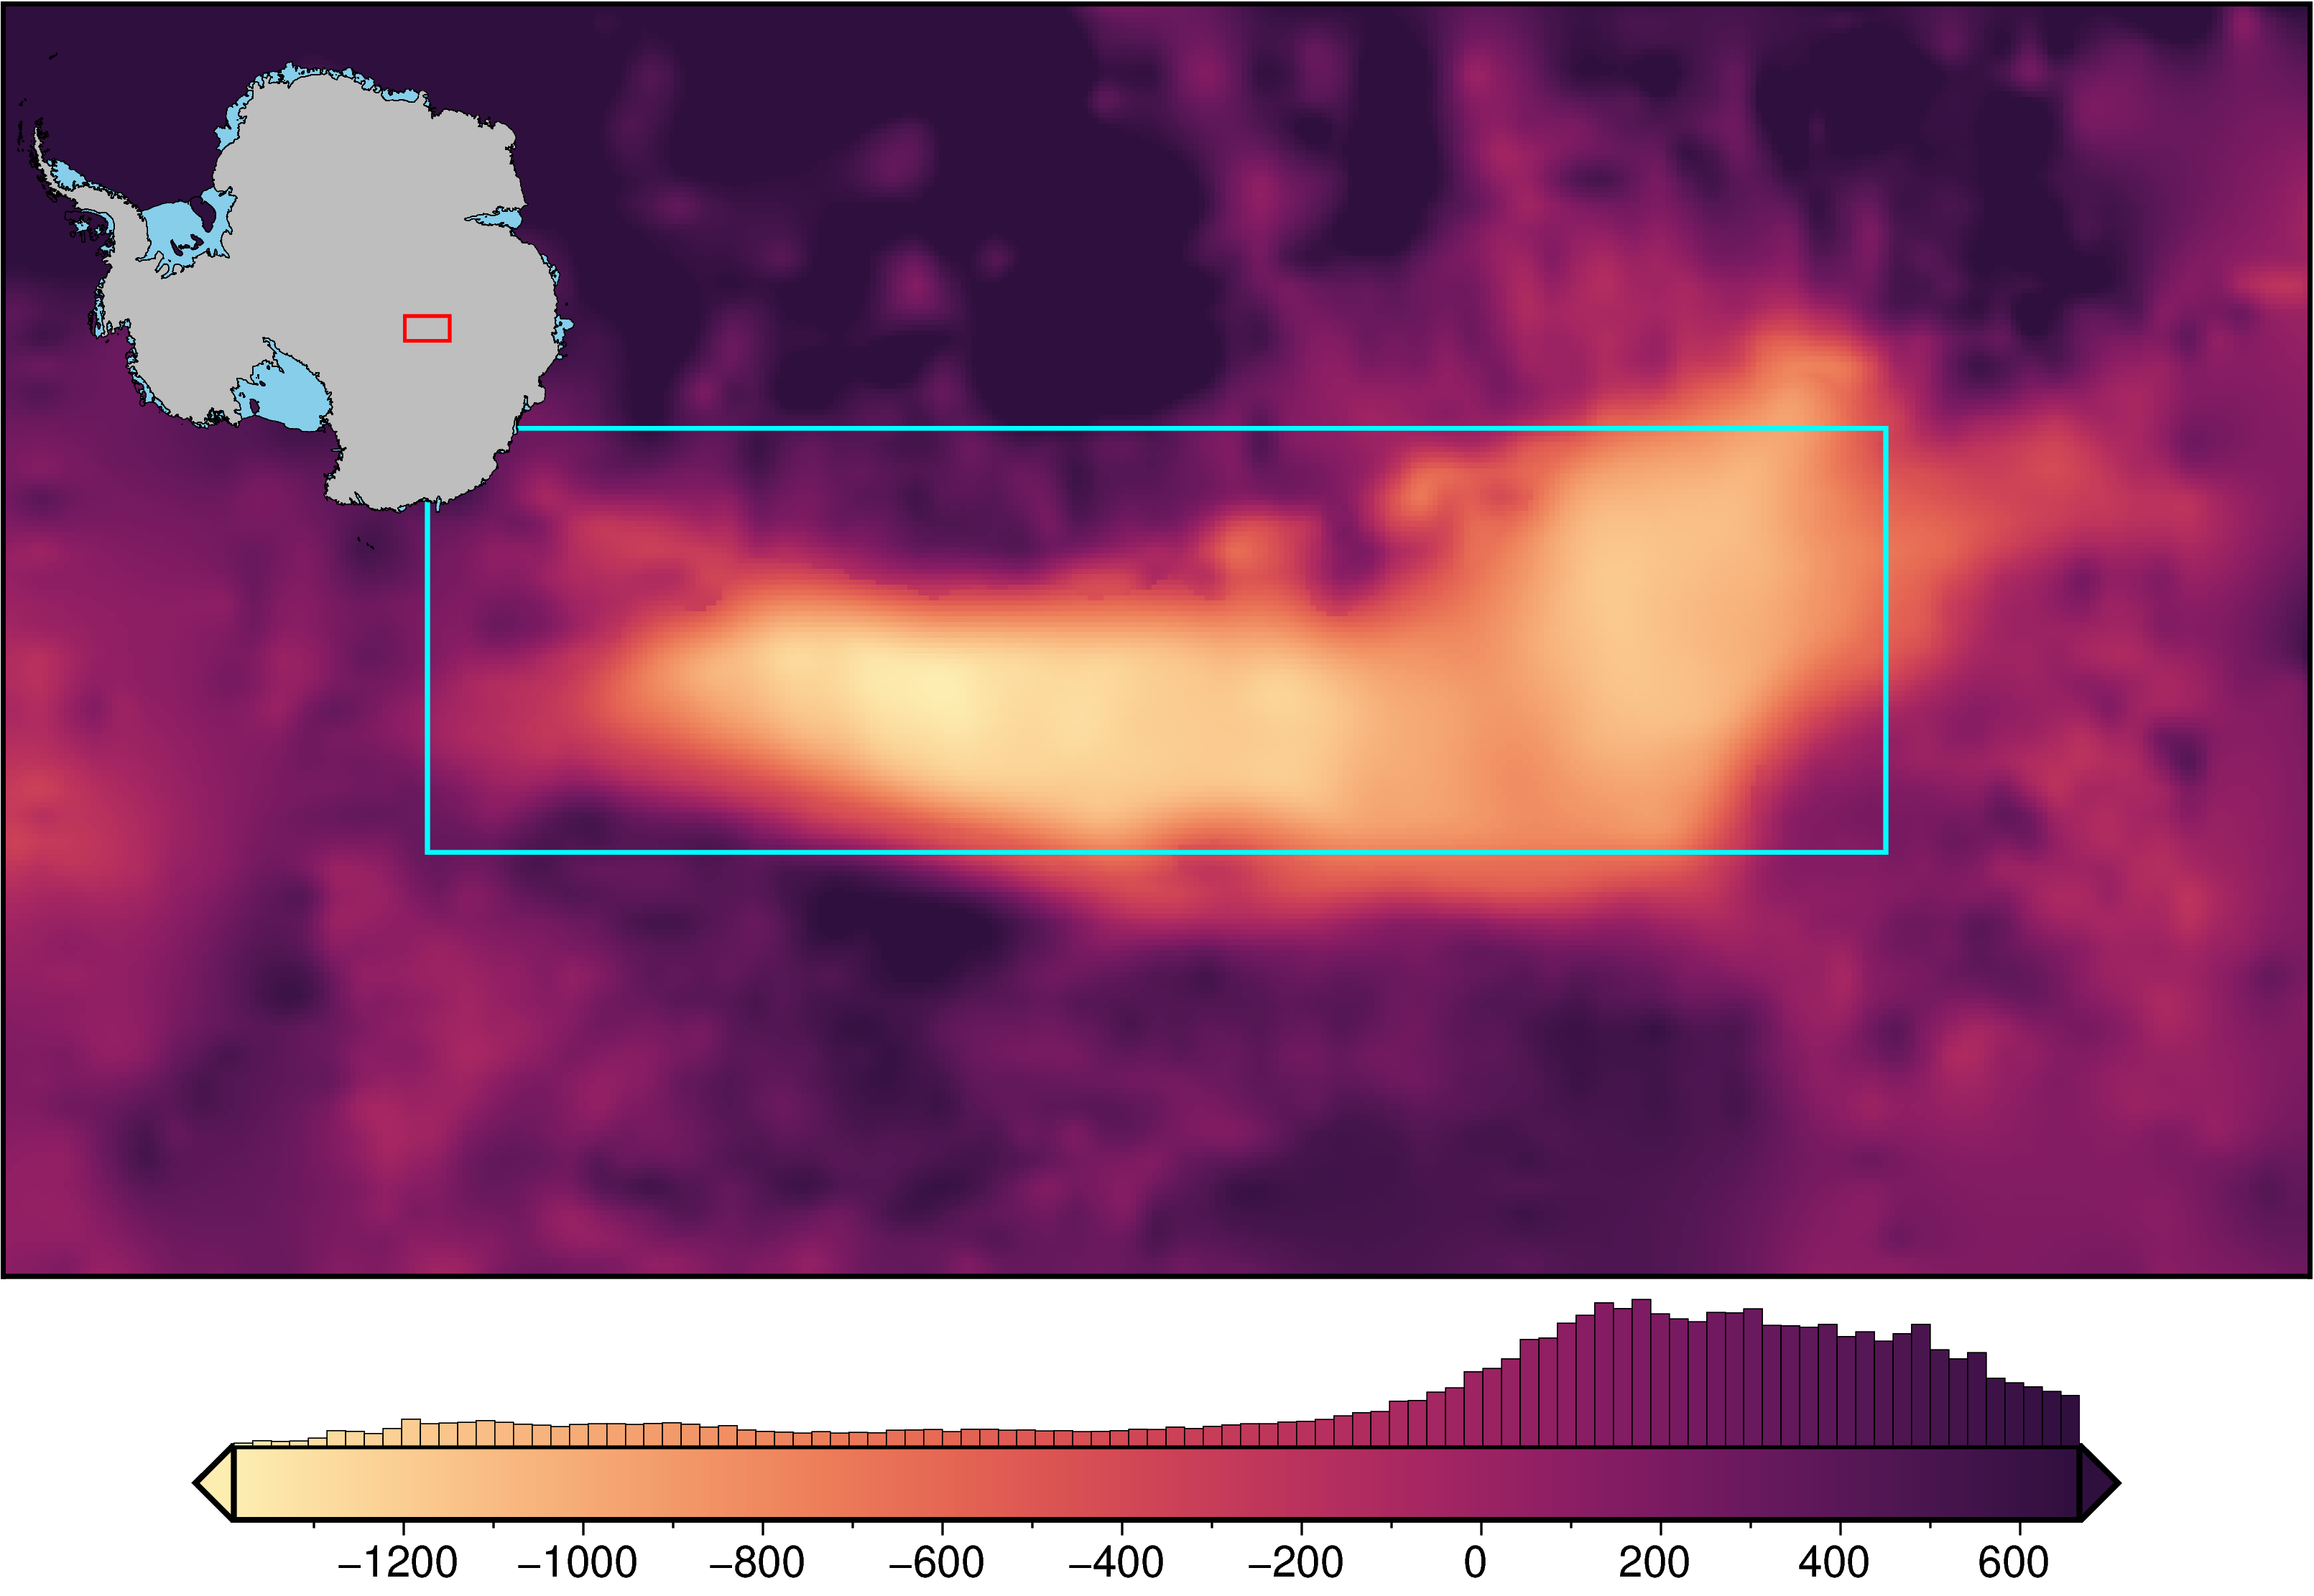

In [22]:
subset_region = regions.alter_region(regions.lake_vostok, zoom=80e3)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    cmap_region=subset_region,  # set the colorscale based on a subset region
    # robust=True, # cmap_region can be combined with robust
    show_region=subset_region,  # show subset region
    region_pen="1.5p,cyan",  # pen for box
)

fig.show()

### Masked grid limits
Define limits with values within a shapefile area

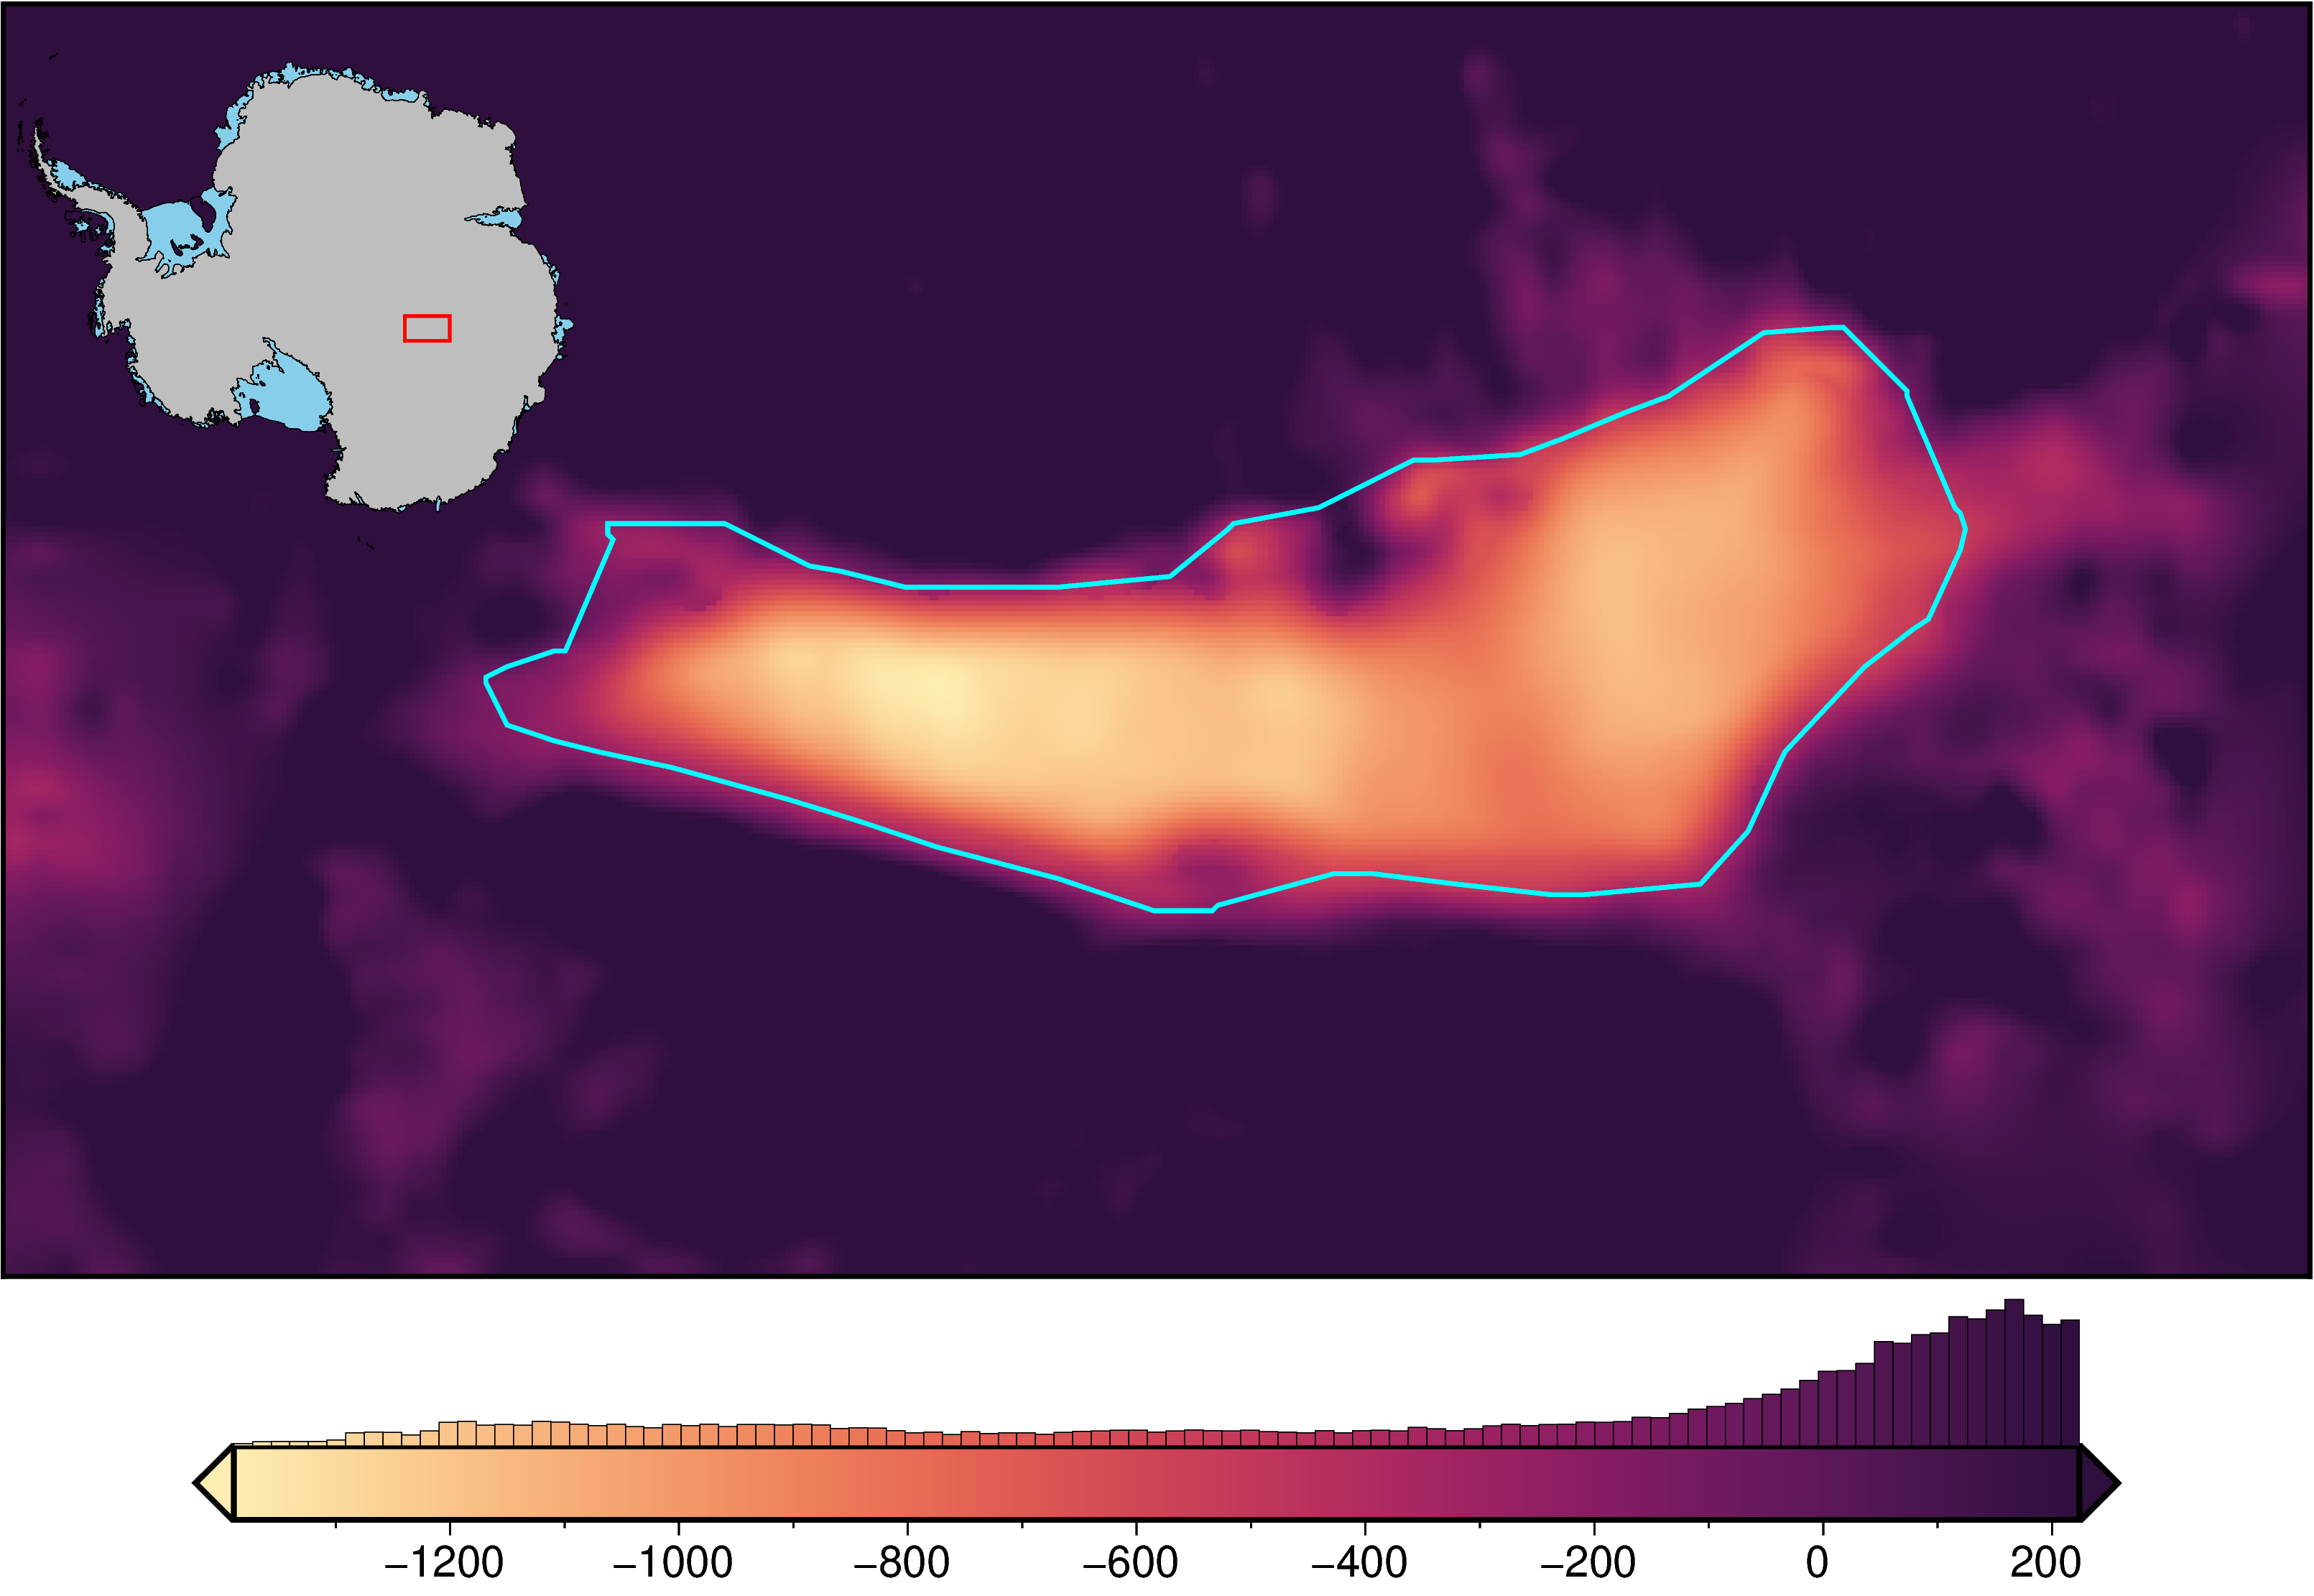

In [23]:
# create a shapefile surrounding lake vostok
mask = fetch.bedmap2(
    layer="lakemask_vostok",
    region=regions.lake_vostok,
)
mask_df = vd.grid_to_table(mask).dropna()
mask_gdf = gpd.GeoDataFrame(mask_df, geometry=gpd.points_from_xy(mask_df.x, mask_df.y))
mask_gdf = mask_gdf.dissolve(by="z").concave_hull(ratio=0.1)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    shp_mask=mask_gdf,  # use a grid values contained within a shapefile to set the
    # color limits
    # robust=True, # shp_mask can be combined with robust
)

fig.plot(
    mask_gdf,
    pen="1.5p,cyan",
)

fig.show()

## Colormap equalization
You can use the argument `grd2cpt` to use PyGMT's grd2cpt function to equalize the colorbar to the data distribution.

grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!
/home/mdtanker/polartoolkit/src/polartoolkit/maps.py:876: UserWarning: getting max/min values from grid, if cpt_lims were used to create the colorscale, histogram will not properly align with colorbar!
  add_colorbar(


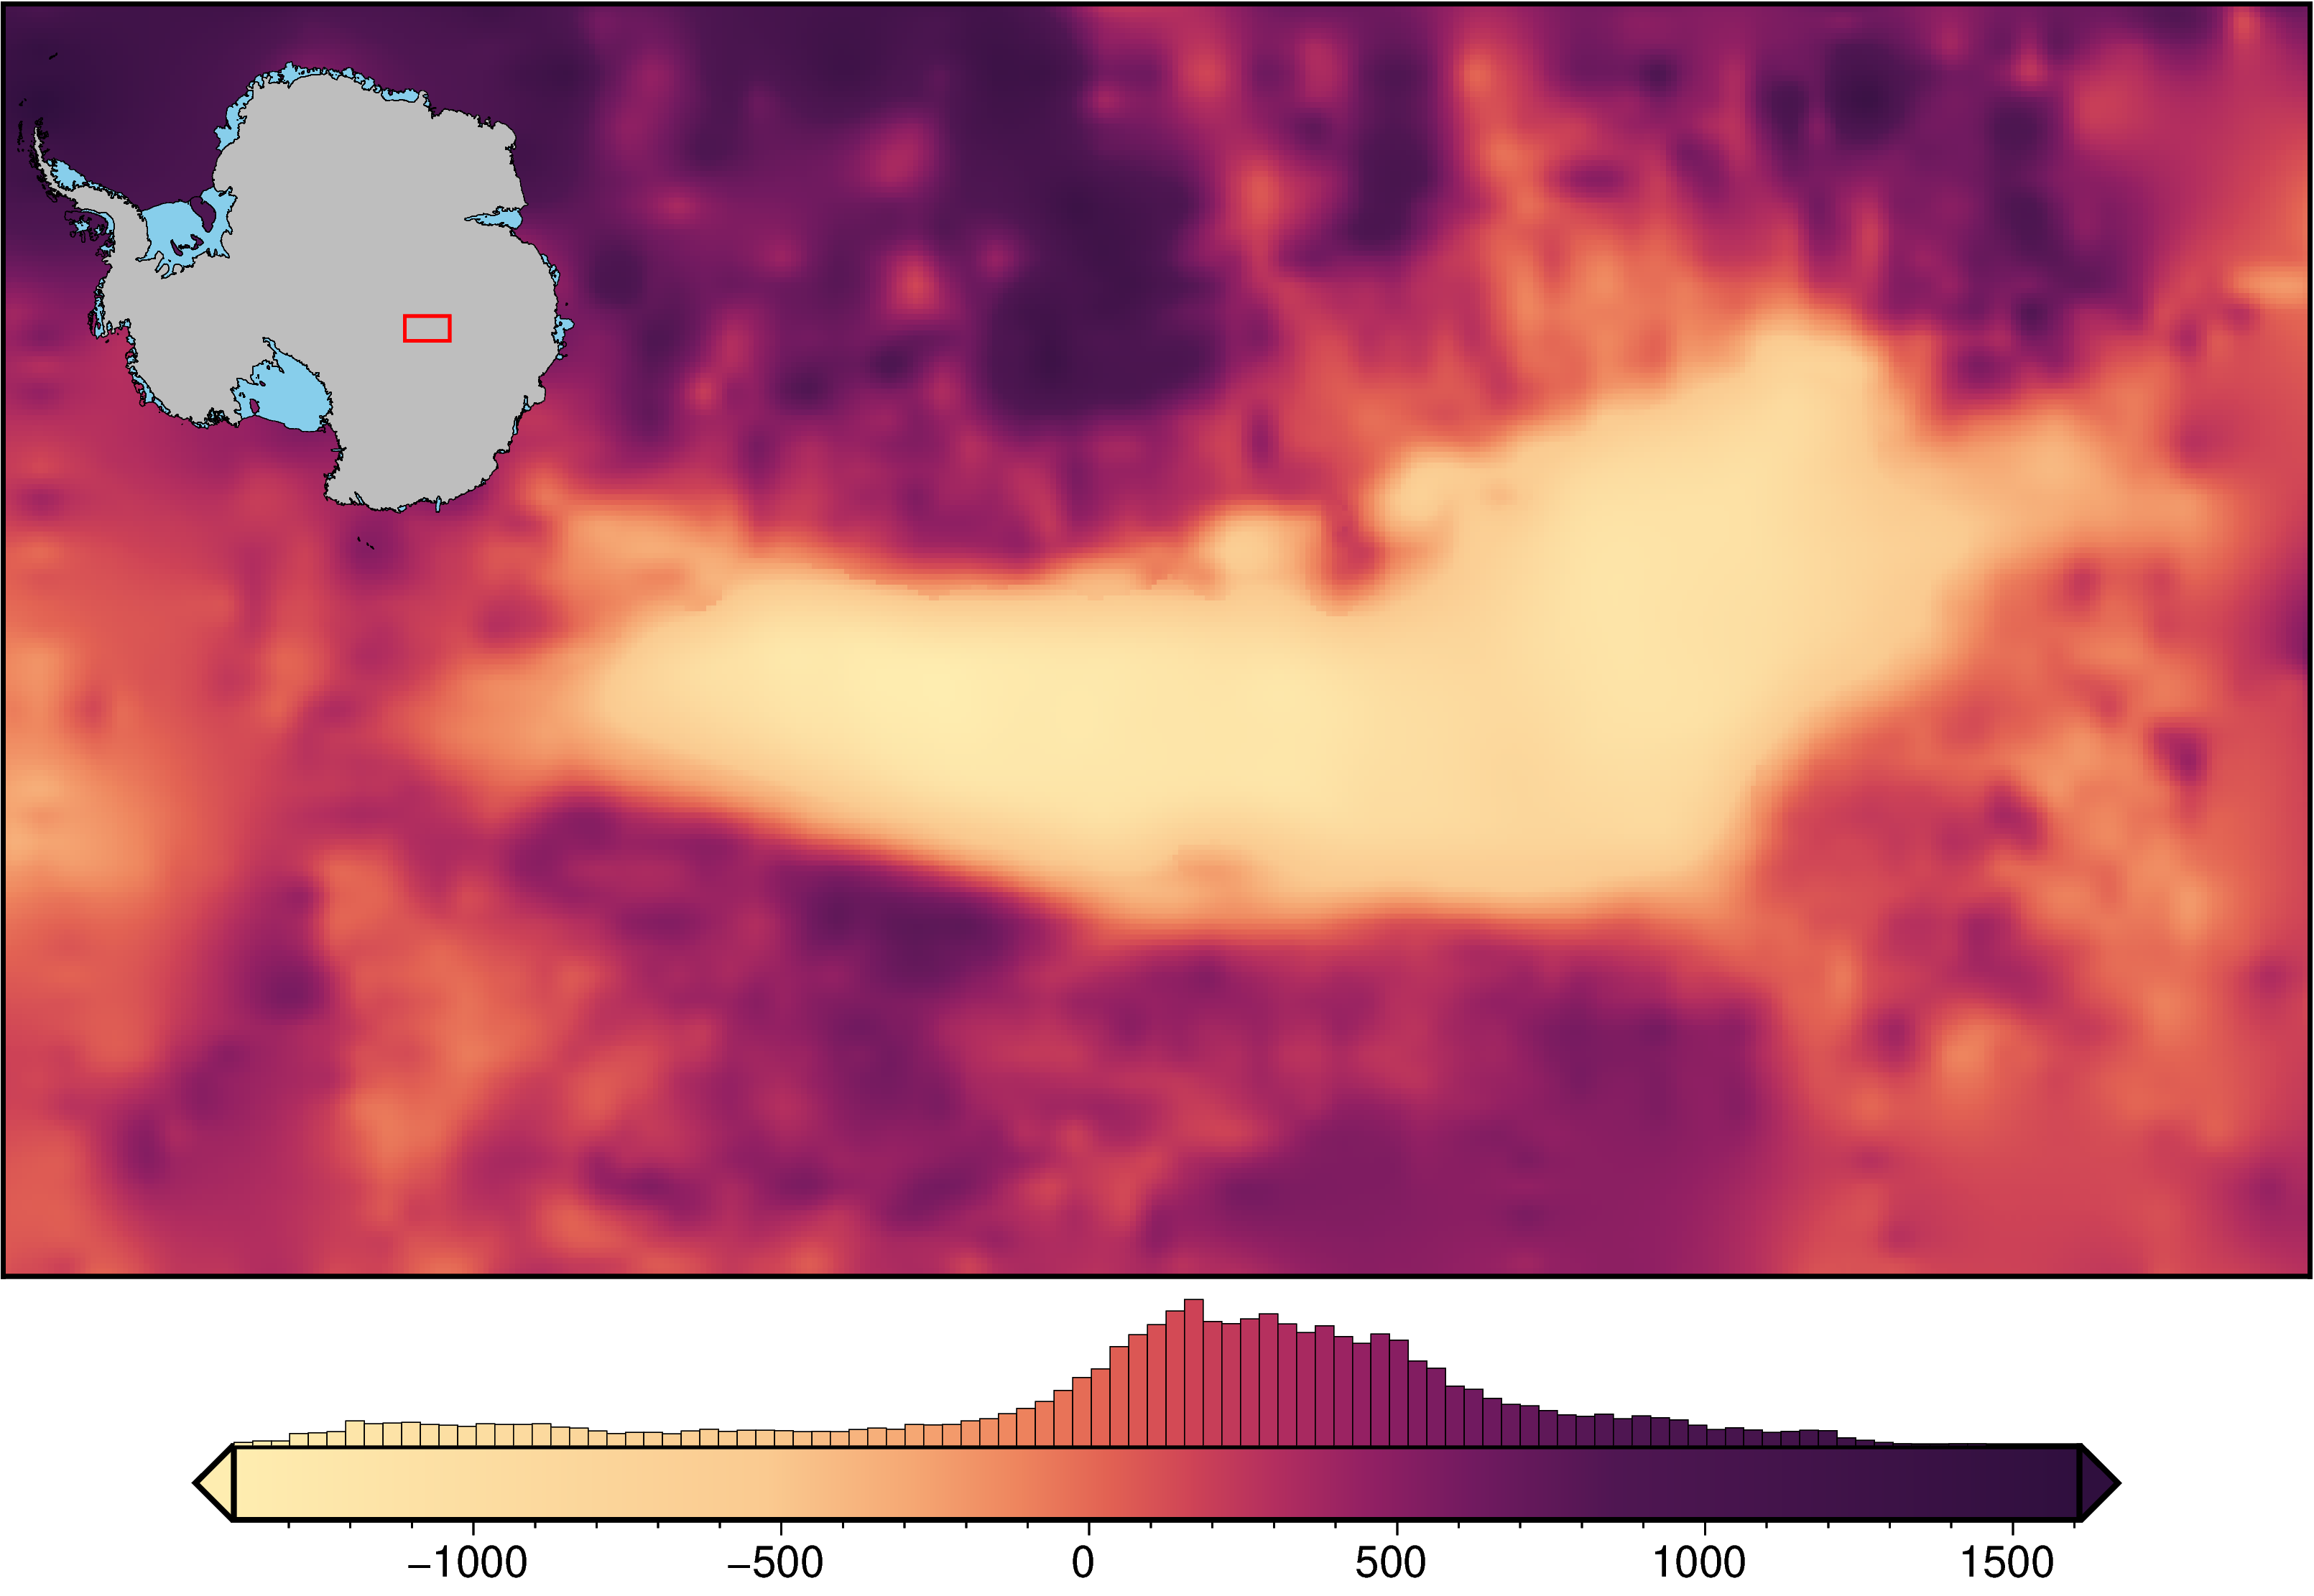

In [24]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    grd2cpt=True,
    # can combine with the following arguments
    # cpt_lims,
    # robust,
    # cmap_region,
    # shp_mask,
)

fig.show()